# Load Dataset

In [ ]:
!pip install kaggle

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import os
import cv2
import numpy as np

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d abdallahwagih/kvasir-dataset-for-classification-and-segmentation

Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation
License(s): CC0-1.0
kvasir-dataset-for-classification-and-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip kvasir-dataset-for-classification-and-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/00687a70-bbad-4bf9-864f-9f7b3c27a2c8.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/0134d93d-0922-4063-9acd-a4177f2b0c07.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/01a57b1a-780f-4e52-9f94-291c2982154d.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/01f092a2-fccb-49f6-af06-8351c8bb47f1.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/022b40a7-a36f-4510-95a1-b6bb709e94ed.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/02b1d319-dea6-418b-969a-c588585cb4f2.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/02de4b4c-8704-45f7-b90f-6004d76bdded.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/0339a2f7-65bb-41fb-8650-e119670b4e2e.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/03ccdf30-eac8-4e3b-b8e5-54fbf64709dd.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/03ea76c5-d60

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

# Custom ImageFolder to exclude specific folders
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None, exclude_folders=None):
        super().__init__(root, transform)
        if exclude_folders:
            self.samples = [
                (path, label) for path, label in self.samples
                if not any(excluded in path for excluded in exclude_folders)
            ]
            self.targets = [s[1] for s in self.samples]

            # Remove unwanted folders from classes and relabel samples
            self.classes = [cls for cls in self.classes if cls not in exclude_folders]
            class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
            self.samples = [(path, class_to_idx[os.path.basename(os.path.dirname(path))]) for path, _ in self.samples]

# Load dataset from the train folder, excluding specific folders
exclude_folders = ['dyed-lifted-polyps', 'dyed-resection-margins']
dataset = CustomImageFolder(root='/content/kvasir-dataset/kvasir-dataset', transform=transform, exclude_folders=exclude_folders)

# Split into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])

# Data loaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print classes (labels), which should now exclude the unwanted folders
classes = dataset.classes
print("Classes:", classes)


Classes: ['esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


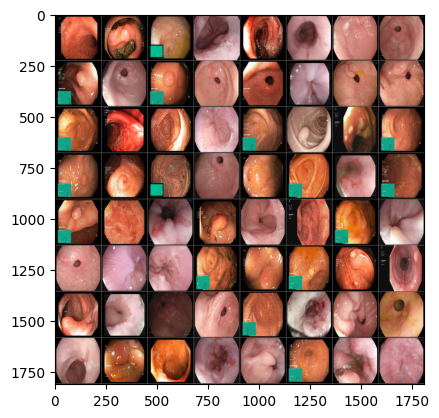

ulcerative-colitis polyps normal-cecum esophagitis ulcerative-colitis esophagitis normal-pylorus normal-pylorus polyps normal-pylorus polyps normal-pylorus normal-pylorus normal-z-line normal-pylorus normal-pylorus normal-cecum ulcerative-colitis normal-cecum esophagitis normal-cecum polyps polyps normal-cecum polyps normal-cecum normal-cecum normal-pylorus ulcerative-colitis normal-cecum esophagitis ulcerative-colitis polyps ulcerative-colitis esophagitis polyps normal-z-line ulcerative-colitis normal-cecum normal-z-line normal-pylorus normal-z-line normal-z-line normal-cecum polyps normal-cecum polyps esophagitis polyps normal-z-line normal-pylorus normal-pylorus normal-cecum esophagitis normal-pylorus normal-pylorus esophagitis polyps ulcerative-colitis esophagitis normal-pylorus normal-cecum esophagitis normal-z-line


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional and Pooling Layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # 64 filters, 3x3 kernel
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)  # 128 filters, 3x3 kernel
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)  # 256 filters, 3x3 kernel
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling

        # Dropout before fully Connected layer
        self.dropout_conv = nn.Dropout(0.5)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 28 * 28, 1024)  # Flattened input size calculation: (224 / 2^3) * (224 / 2^3) * 256
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 6)  # 6 classes for output layer
        # Drop out for convolution layer
        self.dropout_fc = nn.Dropout(0.5)

    def forward(self, x):
        # Forward pass through convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout_conv(x)


        # Flatten the tensor for fully connected layers
        x = torch.flatten(x, 1)

        # Forward pass through fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        x = self.dropout_fc(x)


        # Output layer
        x = self.fc5(x)
        return x



In [ ]:
import torch.optim as optim

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.8)
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [ ]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 75 == 74:    # print every 75 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 75:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [ ]:
PATH = './cnn_gastrointestinaldisease.pth'
torch.save(net.state_dict(), PATH)

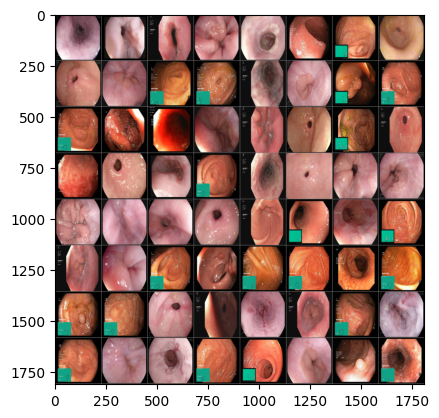

GroundTruth:  esophagitis esophagitis normal-z-line normal-z-line


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_conv): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=200704, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=6, bias=True)
  (dropout_fc): Dropout(p=0.5, inplace=False)
)

In [ ]:
outputs = net(images.to(device)) # Move 'images' to the same device as the model before passing it through the model
images = images.to(device)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  esophagitis normal-z-line normal-z-line normal-pylorus


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
total = 0
correct = 0
# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
                correct += 1
            total += 1
            total_pred[classes[label]] += 1




# Print model accuracy
print("Model accuracy: " + str(100 * correct / total)+ "%")
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Model accuracy: 79.0%
Accuracy for class: esophagitis is 70.5 %
Accuracy for class: normal-cecum is 89.1 %
Accuracy for class: normal-pylorus is 96.6 %
Accuracy for class: normal-z-line is 81.1 %
Accuracy for class: polyps is 64.1 %
Accuracy for class: ulcerative-colitis is 72.9 %


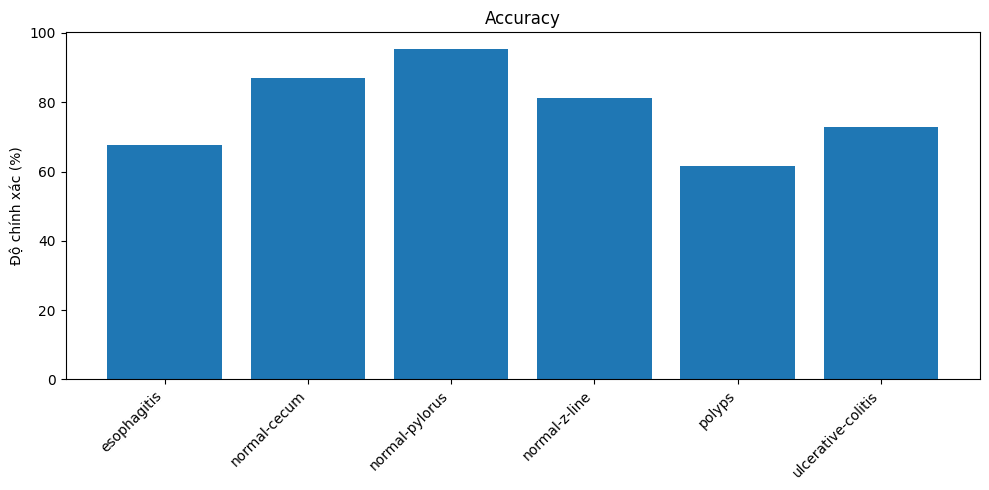

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

accuracies = {classname: correct_pred[classname] / total_pred[classname] * 100 for classname in classes}

plt.figure(figsize=(10, 5))
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Accuracy')
plt.ylabel('Độ chính xác (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()